In [54]:
!wget https://storage.googleapis.com/mledu-datasets/mnist_train_small.csv -O \
    /home/kamal/codes/deepLearning/google_ml_crash_course/mnist_train_small.csv

--2018-06-11 16:36:08--  https://storage.googleapis.com/mledu-datasets/mnist_train_small.csv
Resolving dettdmzlx01.dmz.tt.de.intra.ifm (dettdmzlx01.dmz.tt.de.intra.ifm)... 192.168.250.250
Connecting to dettdmzlx01.dmz.tt.de.intra.ifm (dettdmzlx01.dmz.tt.de.intra.ifm)|192.168.250.250|:3135... connected.
Proxy request sent, awaiting response... 200 OK
Length: 36523880 (35M) [application/octet-stream]
Saving to: ‘/home/kamal/codes/deepLearning/google_ml_crash_course/mnist_train_small.csv’

/home/kamal/codes/d 100%[===================>]  34.83M   204KB/s    in 3m 13s  

2018-06-11 16:39:24 (185 KB/s) - ‘/home/kamal/codes/deepLearning/google_ml_crash_course/mnist_train_small.csv’ saved [36523880/36523880]



In [2]:
import glob
import io
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
mnist_dataframe = pd.read_csv(
  io.open("/tmp/mnist_train_small.csv", "r"),
  sep=",",
  header=None)

# Use just the first 10,000 records for training/validation.
mnist_dataframe = mnist_dataframe.head(10000)

mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
7733,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8795,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1437,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9867,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4565,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
mnist_dataframe.loc[:, 72:72]

,72
7733,0
8795,0
1437,0
9867,0
4565,0
...,...
1267,0
9041,0
9644,0
7516,0


In [9]:
def parse_labels_and_features(dataset):
    labels = dataset[0]
    features = dataset.loc[:,1:784]
    features = features / 255
    return labels, features

In [10]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
training_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.8,0.2,1.0,0.2,0.0,0.0,0.0,0.0


In [11]:
validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])
validation_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,...,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


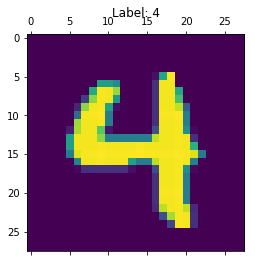

In [48]:
random_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
ax.matshow(training_examples.loc[random_example].values.reshape(28, 28))
ax.set_title("Label: %i" %training_targets.loc[random_example])
ax.grid(False)

In [13]:
def construct_feature_columns():
    return set([tf.feature_column.numeric_column('pixels', shape=784)])

In [77]:
def create_training_input_fun(features, labels, batch_size, num_epochs = None, shuffle = True):
    def input_fun(num_epochs = None, shuffle = True):
        index = np.random.permutation(features.index)
        raw_features = {"pixels":features.reindex(index)}
        raw_targets = np.array(labels[index])
    
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size).repeat(num_epochs)
        if shuffle:
            ds = ds.shuffle(10000)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return input_fun

In [78]:
def create_predict_input_fun(features, labels, batch_size):
    def input_fun():
        raw_features = {"pixels":features.values}
        raw_targets = np.array(labels)
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return input_fun

In [79]:
def train_linear_classification_model(learning_rate, steps, batch_size, training_examples, training_targets, 
                                      validation_examples, validation_targets):
    periods = 10 
    steps_per_period = steps / periods
    predict_training_input_fun = create_predict_input_fun(training_examples, training_targets, batch_size)
    predict_validation_input_fun = create_predict_input_fun(validation_examples, validation_targets, batch_size)
    training_input_fun = create_training_input_fun(training_examples, training_targets, batch_size)
    
    my_optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.LinearClassifier(feature_columns = construct_feature_columns(), 
                                               n_classes = 10, optimizer = my_optimizer, 
                                               config = tf.estimator.RunConfig(keep_checkpoint_max = 1))
    print("Training Model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range(0, periods):
        classifier.train(input_fn = training_input_fun, steps = steps_per_period)
        training_predictions = list(classifier.predict(input_fn = predict_training_input_fun))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 10)
        
        validation_predictions = list(classifier.predict(input_fn = predict_validation_input_fun))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 10)
        
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        print("Period %0d: %0.2f" %(period, validation_log_loss))
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model Training Finished")
    
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
    final_predictions = classifier.predict(input_fn = predict_validation_input_fun)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
    
    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation_data): %0.2f" % accuracy)
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label = "training")
    plt.plot(validation_errors, label = "validation")
    plt.legend()
    plt.show()
    
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    cm_normalized = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap = "bone_r")
    ax.set_aspect(1)
    plt.title("confusion Matrix")
    plt.ylabel("true label")
    plt.xlabel("predicted label")
    plt.show()
    return classifier

Training Model...
LogLoss error (on validation data):
Period 0: 4.42
Period 1: 3.79
Period 2: 3.61
Period 3: 3.61
Period 4: 3.55
Period 5: 3.50
Period 6: 3.48
Period 7: 3.44
Period 8: 3.44
Period 9: 3.37
Model Training Finished
Final accuracy (on validation_data): 0.90


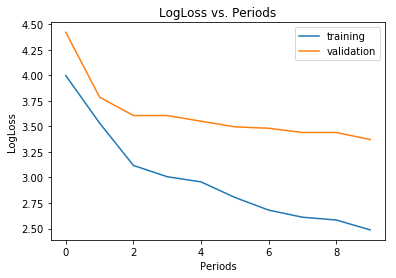

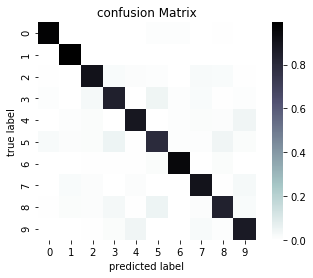

In [80]:
_ = train_linear_classification_model(learning_rate = 0.03, steps = 1000, batch_size = 50,
                                      training_examples = training_examples, training_targets = training_targets,
                                      validation_examples = validation_examples, validation_targets = validation_targets)

In [51]:
def train_nn_classification_model(learning_rate, steps, batch_size, hidden_units, training_examples, training_targets, 
                                  validation_examples, validation_targets):
    periods = 10
    steps_per_period = steps / periods
    predict_training_input_fun = create_predict_input_fun(training_examples, training_targets, batch_size)
    predict_validation_input_fun = create_predict_input_fun(validation_examples, validation_targets, batch_size)
    training_input_fun = create_training_input_fun(training_examples, training_targets, batch_size)
    feature_columns = [tf.feature_column.numeric_column('pixels', shape = 784)]
    my_optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(feature_columns = feature_columns, n_classes = 10, 
                                            hidden_units = hidden_units, optimizer = my_optimizer, 
                                            config = tf.contrib.learn.RunConfig(keep_checkpoint_max = 1))
    print("Training Model...")
    print("LogLoss error (on validation data)")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        classifier.train(input_fn = training_input_fun, steps = steps_per_period)
        training_predictions = list(classifier.predict(input_fn = predict_training_input_fun))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 10)
        
        validation_predictions = list(classifier.predict(input_fn = predict_validation_input_fun))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 10)
        
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        print("Period %02d: %0.2f" %(period, validation_log_loss))
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model Training Finished")
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
    final_predictions = classifier.predict(input_fn=predict_validation_input_fun)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)
    
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label = "training")
    plt.plot(validation_errors, label = "validation")
    plt.legend()
    plt.show()
    
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    cm_normalized = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

Training Model...
LogLoss error (on validation data)
Period 00: 5.77
Period 01: 4.38
Period 02: 2.85
Period 03: 2.53
Period 04: 2.51
Period 05: 2.00
Period 06: 2.09
Period 07: 2.20
Period 08: 1.95
Period 09: 1.81
Model Training Finished
Final accuracy (on validation data): 0.95


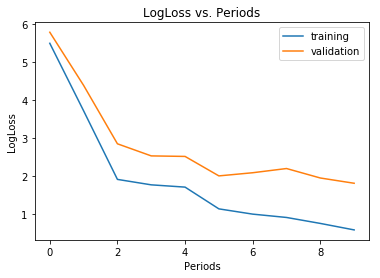

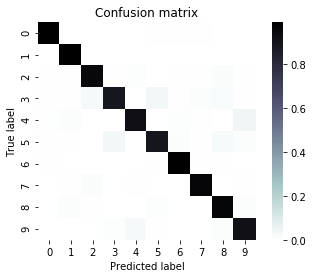

In [52]:
classifier = train_nn_classification_model(
    learning_rate=0.05,
    steps=1000,
    batch_size=30,
    hidden_units=[100, 100],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [82]:
!wget https://storage.googleapis.com/mledu-datasets/mnist_test.csv -O \
    /home/kamal/codes/deepLearning/google_ml_crash_course/mnist_test.csv

--2018-06-11 19:22:17--  https://storage.googleapis.com/mledu-datasets/mnist_test.csv
Resolving dettdmzlx01.dmz.tt.de.intra.ifm (dettdmzlx01.dmz.tt.de.intra.ifm)... 192.168.250.250
Connecting to dettdmzlx01.dmz.tt.de.intra.ifm (dettdmzlx01.dmz.tt.de.intra.ifm)|192.168.250.250|:3135... connected.
Proxy request sent, awaiting response... 200 OK
Length: 18289443 (17M) [application/octet-stream]
Saving to: ‘/home/kamal/codes/deepLearning/google_ml_crash_course/mnist_test.csv’

/home/kamal/codes/d 100%[===================>]  17.44M   218KB/s    in 93s     

2018-06-11 19:23:52 (191 KB/s) - ‘/home/kamal/codes/deepLearning/google_ml_crash_course/mnist_test.csv’ saved [18289443/18289443]



In [87]:
mnist_test_dataframe = pd.read_csv(io.open("/tmp/mnist_test.csv", "r"),
  sep=",",
  header=None)
test_targets, test_examples = parse_labels_and_features(mnist_test_dataframe)
test_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
predict_test_input_fun = create_predict_input_fun(test_examples, test_targets, batch_size = 100)
test_predictions = classifier.predict(input_fn = predict_test_input_fun)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy on test data: %0.2f" %accuracy)

Accuracy on test data: 0.95


['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights0 shape : (784, 100)


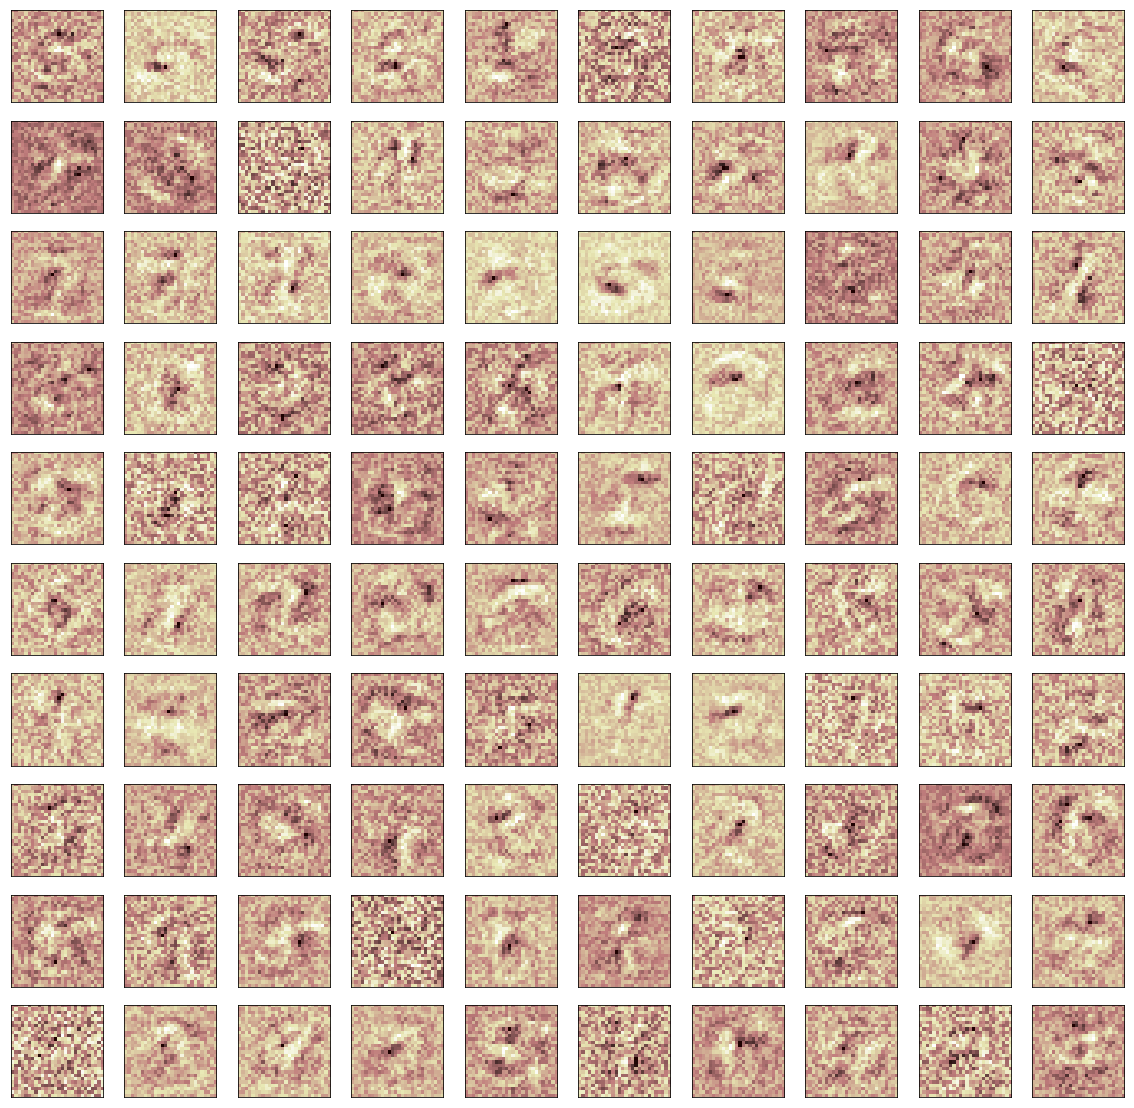

In [90]:
print(classifier.get_variable_names())
weights0 = classifier.get_variable_value("dnn/hiddenlayer_0/kernel")
print("weights0 shape :", weights0.shape)
num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap = plt.cm.pink)
    ax.set_xticks(())
    ax.set_yticks(())
    
plt.show()